In [1]:
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
from pathlib import Path
from typing import List
from typing import Any
import json
import os
import numpy as np
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import mean_squared_error
import pandas as pd
from scipy.stats import pearsonr, linregress

import helper

/gpfs1/home/c/p/cpetak/CA_GRN2/helper.py:163: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = windows.dot(grn)
/gpfs1/home/c/p/cpetak/CA_GRN2/helper.py:184: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = gene_vals.dot(internal_grn)


In [2]:
rules=[22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102]

num_cells = 22
dev_steps = 22
try_seedints = [69904,149796]

ones_1=[]
ones_2=[]
perc_overlaps=[]
overlap_ones = []
for rule in rules:
    all_targs=[]
    for s in try_seedints:
        start_pattern = helper.seedID2string(s, num_cells)
        targets = helper.rule2targets_wrapped_wstart(rule, L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
        all_targs.append(targets)

    ones_1.append(sum(all_targs[0]).sum()/(22*23))
    ones_2.append(sum(all_targs[1]).sum()/(22*23))
    #diff1s = abs(env11s-env21s)

    where_overlap = np.where(all_targs[0]==all_targs[1])
    perc_overlaps.append(len(all_targs[0][where_overlap])/(22*23))
    overlap_ones.append(sum(all_targs[0][where_overlap])/len(all_targs[0][where_overlap])) #percent 1s



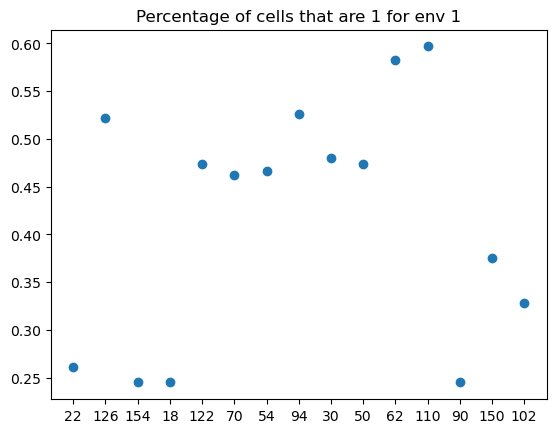

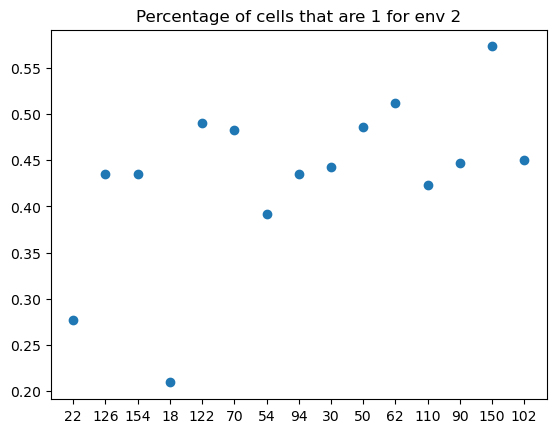

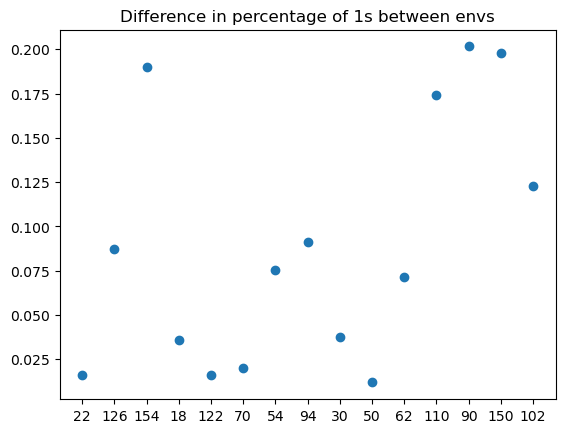

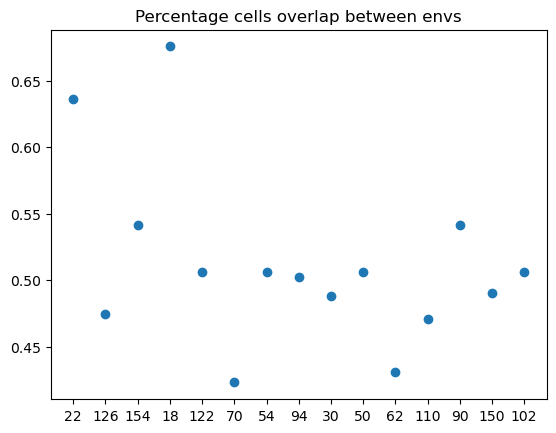

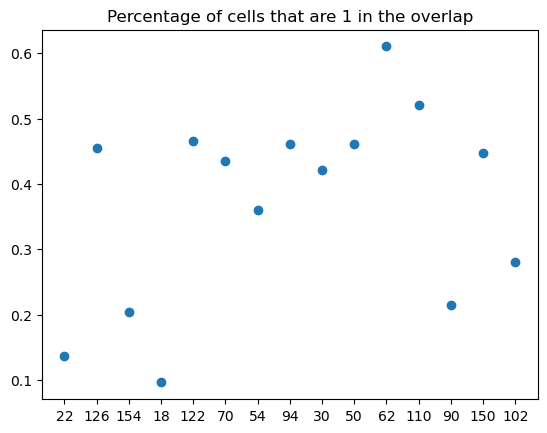

In [3]:
plt.scatter(list(range(len(rules))),ones_1)
plt.xticks(ticks=range(0, len(rules)), labels=rules)
plt.title("Percentage of cells that are 1 for env 1")
plt.show()

plt.scatter(list(range(len(rules))),ones_2)
plt.xticks(ticks=range(0, len(rules)), labels=rules)
plt.title("Percentage of cells that are 1 for env 2")
plt.show()

plt.scatter(list(range(len(rules))),abs(np.array(ones_2)-np.array(ones_1)))
plt.xticks(ticks=range(0, len(rules)), labels=rules)
plt.title("Difference in percentage of 1s between envs")
plt.show()

plt.scatter(list(range(len(rules))),perc_overlaps)
plt.xticks(ticks=range(0, len(rules)), labels=rules)
plt.title("Percentage cells overlap between envs")
plt.show()

plt.scatter(list(range(len(rules))),overlap_ones)
plt.xticks(ticks=range(0, len(rules)), labels=rules)
plt.title("Percentage of cells that are 1 in the overlap")
plt.show()

In [4]:
def custom_legend(ax, title, n=5):
    """
    Reduce the number of entries in the Legend,
    by only showing first,last and every n-th
    """
    handles, labels = ax.get_legend_handles_labels()
    if len(handles) <= n + 2:
        return ax.legend(title=title)
    new_handles = [handles[0]] + handles[1:-1:n] + [handles[-1]]
    new_labels = [labels[0]] + labels[1:-1:n] + [labels[-1]]
    return ax.legend(new_handles, new_labels, title=title)


class JSONLogger:
    def __init__(self, filepath: str):
        self.filepath = Path(filepath)
        self.filepath.parent.mkdir(parents=True, exist_ok=True)

    def append(self, results: Any) -> None:
        with self.filepath.open("a") as f:
            f.write(json.dumps(results) + "\n")

    def read(self) -> list:
        results = []
        with open(self.filepath) as f:
            results = [json.loads(line) for line in f]
        return results

In [5]:
root="~/scratch/detailed_save/"
exp_type = "variable"
candidate_idx = -1

M = 0.3
N = 20
sigma = 1000  # Smoothing parameter, adjust as needed

In [6]:
rules=[22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102]
diff0s=[]
diff50s=[]
smooths=[]
for r in rules:
    filename = os.path.expanduser(f"{root}/noise_results/stats_{r}_{exp_type}_{candidate_idx}_noise_data.jsonl")
    #filename = os.path.expanduser(f"{root}/noise_results/stats_{r}_randomGRN_noise_data.jsonl")
    log = JSONLogger(filename)
    diff0=[]
    diff50=[]
    rmses=[]
    all_data = log.read()
    for exp in all_data:
        if "69904" in Path(exp["file"]).name:
            data = exp["data"]
            for i, (fitnesses, noise) in enumerate(zip(data, np.linspace(0, M, N))):
                #y_smoothed = gaussian_filter1d(fitnesses, sigma=sigma)
                #rmse = np.sqrt(mean_squared_error(fitnesses, y_smoothed)) # Calculate RMSE between the original and smoothed line
                #print(rmse)
                if noise == 0:
                    base_fit = fitnesses[0]
                if i == 4:
                    #print(noise)
                    mean_noise = sum(fitnesses)/len(fitnesses) #np.std(np.abs(np.array(fitnesses)[1:] - np.array(fitnesses)[:-1]))
                    rmse = base_fit - mean_noise
                    rmses.append(rmse)
                if noise == 0.3:
                    high_noise_fit = fitnesses[0]
                    diff0.append(base_fit - high_noise_fit)
                    high_noise_fit = fitnesses[int(len(fitnesses)/2)]
                    diff50.append(base_fit - high_noise_fit)
    diff0s.append(diff0)
    diff50s.append(diff50)
    smooths.append(rmses)
    #print(np.array(rmses).shape)
    #smooths.append(np.array(rmses).mean(axis=0))

In [7]:
rules=[22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102]
root="~/scratch/detailed_save/"
exp_type = "variable"
candidate_idx = -1
vdata=[]
for rule in rules:
    filename = os.path.expanduser(f"{root}/noise_results/testing/stats_{rule}_{exp_type}_{candidate_idx}_pheno_data.csv")
    df = pd.read_csv(filename)
    #print(df)
    vdata.append(df["Pheno_dists1"].to_list())
    #break

In [14]:
rules=[22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102]
root="~/scratch/detailed_save/"
exp_type = "static"
candidate_idx = -1
sdata=[]
for rule in rules:
    filename = os.path.expanduser(f"{root}/noise_results/testing/stats_{rule}_{exp_type}_{candidate_idx}_pheno_data.csv")
    df = pd.read_csv(filename)
    #print(df)
    sdata.append(df["Pheno_dists1"].to_list())
    #break

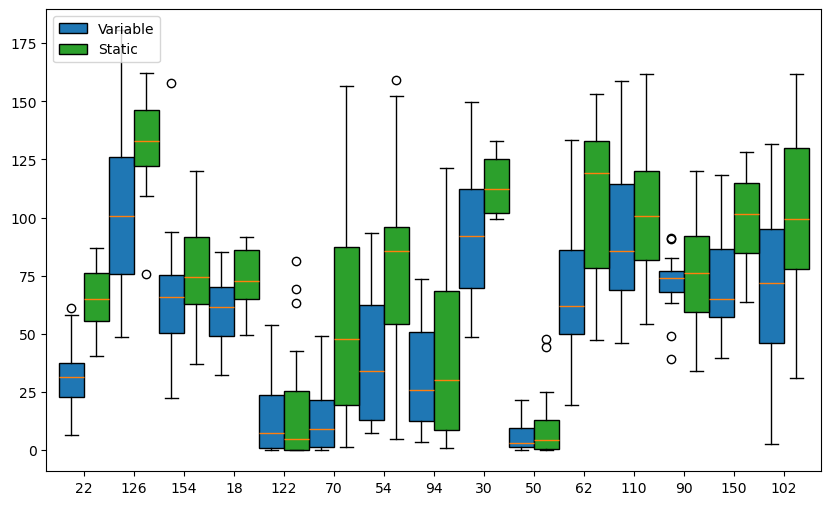

In [15]:
# Create the plot
plt.figure(figsize=(10, 6))

positions1 = np.arange(1, len(vdata) + 1) - 0.25  # Shift left for the first set
positions2 = np.arange(1, len(sdata) + 1) + 0.25  # Shift right for the second set

box1=plt.boxplot(vdata, positions=positions1, patch_artist=True)
for patch in box1['boxes']:
    patch.set_facecolor("C0")
box2=plt.boxplot(sdata, positions=positions2, patch_artist=True)
for patch in box2['boxes']:
    patch.set_facecolor("C2")

plt.legend([box1["boxes"][0], box2["boxes"][0]], ["Variable", "Static"], loc="upper left")
plt.xticks(ticks=range(1, len(rules) + 1), labels=rules)
plt.show()

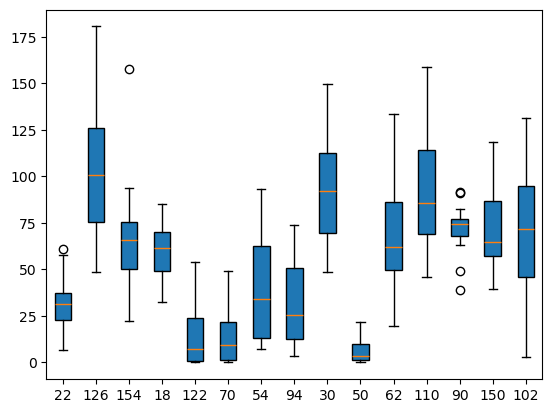

In [10]:
box1=plt.boxplot(vdata, patch_artist=True)
for patch in box1['boxes']:
    patch.set_facecolor("C0")
plt.xticks(ticks=range(1, len(rules) + 1), labels=rules)
plt.show()

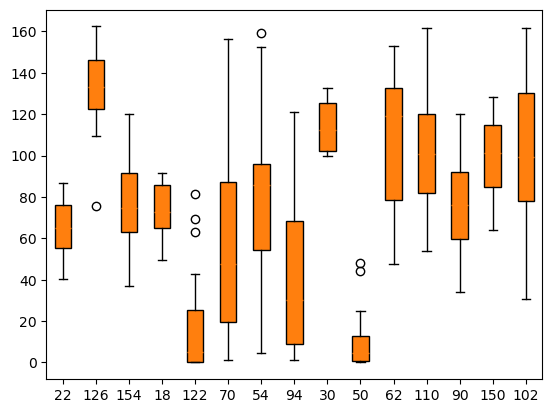

In [11]:
box2=plt.boxplot(smooths, patch_artist=True)
for patch in box2['boxes']:
    patch.set_facecolor("C1")
plt.xticks(ticks=range(1, len(rules) + 1), labels=rules)
plt.show()

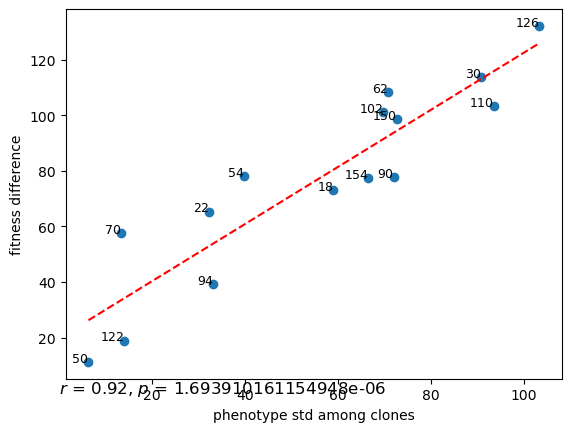

In [12]:
x = np.array(vdata).mean(axis=1)
y = np.array(smooths).mean(axis=1)
plt.scatter(x,y)
#plt.plot([x.min(),x.max() ], [y.min(), y.max()], color='red', linestyle='--')

slope, intercept, r_value, p_value, std_err = linregress(x, y)
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, color='red', linestyle='--', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')
plt.text(0.02, 0.15, f'$r$ = {r_value:.2f}, $p$ = {p_value}',fontsize=12)

plt.ylabel("fitness difference")
plt.xlabel("phenotype std among clones")
for i, label in enumerate(rules):
    plt.text(x[i], y[i], label, fontsize=9, ha='right')

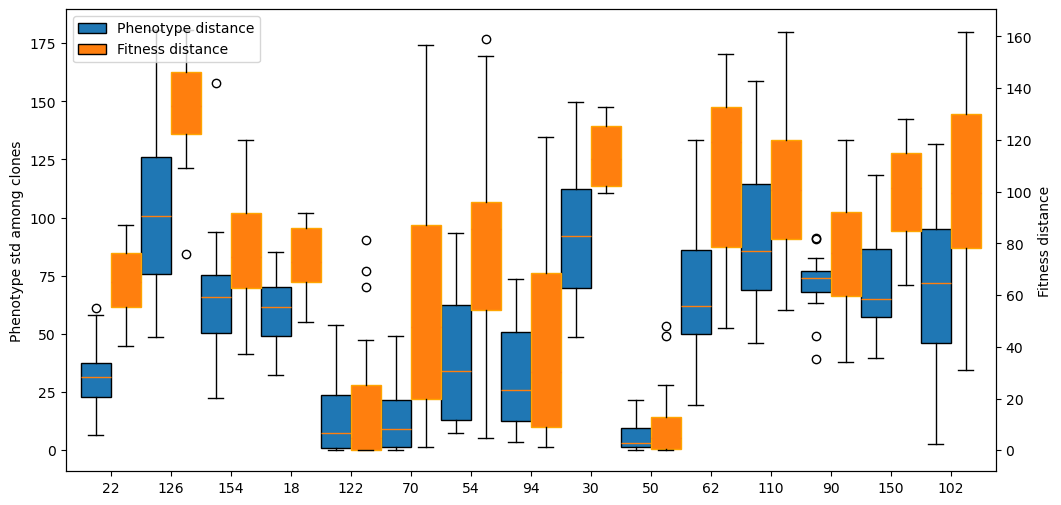

In [13]:
import matplotlib.pyplot as plt

# Sample data for the two boxplot sets
data1 = vdata
data2 = smooths

positions1 = np.arange(1, len(vdata) + 1) - 0.25  # Shift left for the first set
positions2 = np.arange(1, len(smooths) + 1) + 0.25  # Shift right for the second set

fig, ax1 = plt.subplots(figsize=(12,6))

# First boxplot on ax1
boxplot1 = ax1.boxplot(data1, positions=positions1, patch_artist=True)
ax1.set_ylabel("Phenotype std among clones")
#ax1.set_title("Boxplots with Two Y-Axis Ranges")

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
boxplot2 = ax2.boxplot(data2, positions=positions2, patch_artist=True, boxprops=dict(color="orange"))
ax2.set_ylabel("Fitness distance")

# Customize colors or other aesthetics for clarity if needed
for box in boxplot1['boxes']:
    box.set_facecolor("C0")
for box in boxplot2['boxes']:
    box.set_facecolor("C1")

plt.legend([box1["boxes"][0], box2["boxes"][0]], ["Phenotype distance", "Fitness distance"], loc="upper left")

plt.xticks(ticks=range(1, len(rules) + 1), labels=rules)
plt.show()


In [15]:
#vari_smooths = smooths.copy()
static_smooths = smooths.copy()

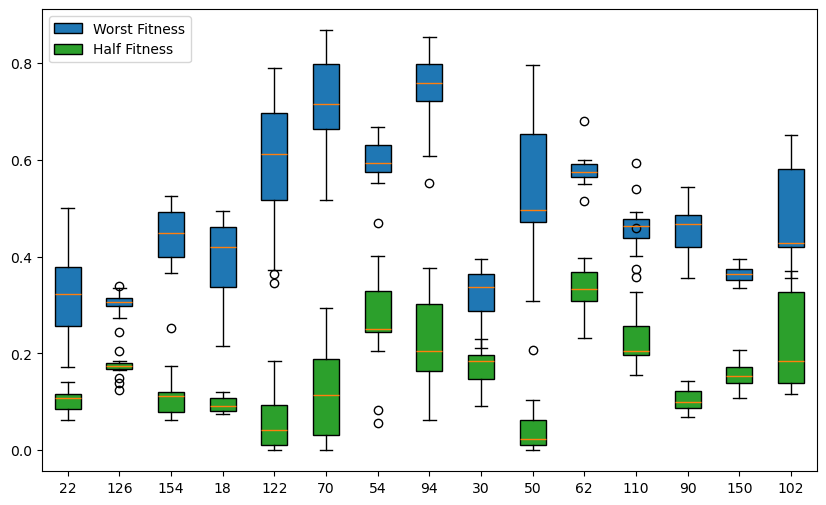

In [57]:
# Create the plot
plt.figure(figsize=(10, 6))

box1=plt.boxplot(diff0s, patch_artist=True)
for patch in box1['boxes']:
    patch.set_facecolor("C0")
box2=plt.boxplot(diff50s, patch_artist=True)
for patch in box2['boxes']:
    patch.set_facecolor("C2")

plt.legend([box1["boxes"][0], box2["boxes"][0]], ["Worst Fitness", "Half Fitness"], loc="upper left")
plt.xticks(ticks=range(1, len(rules) + 1), labels=rules)
plt.show()

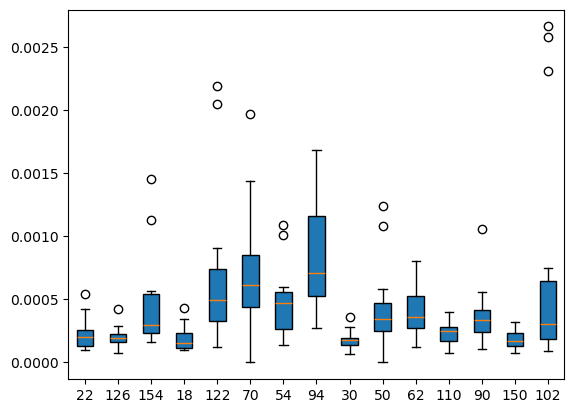

In [58]:
#for idx, s in enumerate(smooths):
    #plt.plot(s[1:],label=rules[idx])
#plt.legend(loc="right")
#plt.show()
plt.boxplot(smooths, patch_artist=True)
plt.xticks(ticks=range(1, len(rules) + 1), labels=rules)

plt.show()

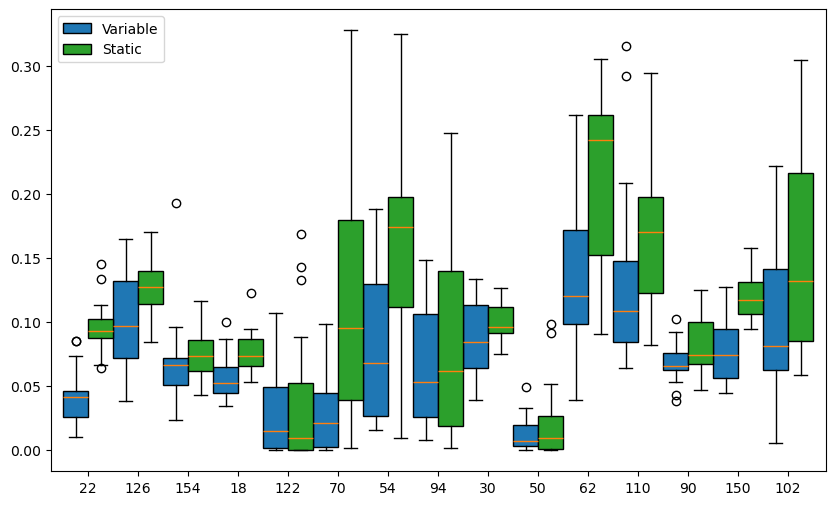

In [16]:
# Create the plot
plt.figure(figsize=(10, 6))

positions1 = np.arange(1, len(vari_smooths) + 1) - 0.25  # Shift left for the first set
positions2 = np.arange(1, len(static_smooths) + 1) + 0.25  # Shift right for the second set

box1=plt.boxplot(vari_smooths, positions=positions1, patch_artist=True)
for patch in box1['boxes']:
    patch.set_facecolor("C0")
box2=plt.boxplot(static_smooths, positions=positions2, patch_artist=True)
for patch in box2['boxes']:
    patch.set_facecolor("C2")

plt.legend([box1["boxes"][0], box2["boxes"][0]], ["Variable", "Static"], loc="upper left")
plt.xticks(ticks=range(1, len(rules) + 1), labels=rules)
plt.show()

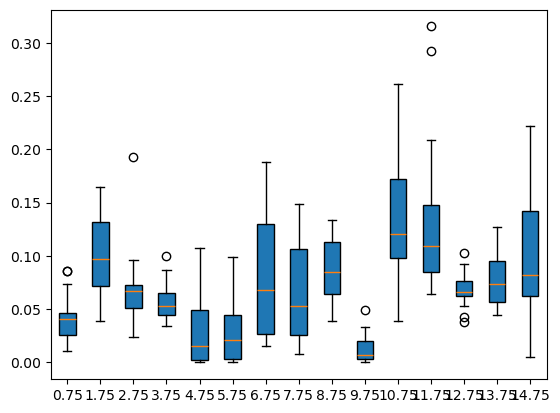

In [20]:
box1=plt.boxplot(smooths, positions=positions1, patch_artist=True)
for patch in box1['boxes']:
    patch.set_facecolor("C0")

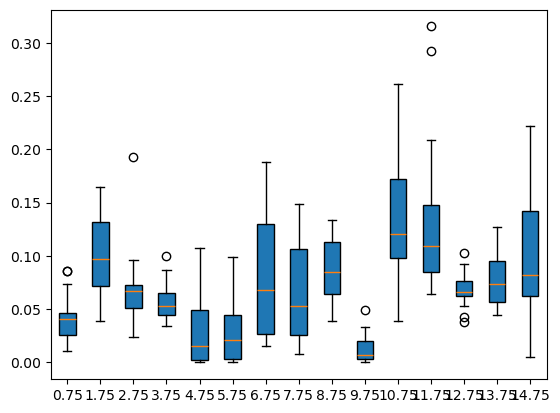

In [23]:
box1=plt.boxplot(smooths, positions=positions1, patch_artist=True)
for patch in box1['boxes']:
    patch.set_facecolor("C0")

In [19]:
np.array(vari_smooths).shape

(15, 15)

In [14]:
#22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102
root="~/scratch/detailed_save/"
candidate_idx=299
rule = 122
M = 0.3
N = 20
exp_type = "variable"
#filename = os.path.expanduser(f"{root}/noise_results/stats_{rule}_{exp_type}_{candidate_idx}_noise_data.jsonl")
#filename = os.path.expanduser(f"{root}/noise_results/stats_{rule}_randomGRN_noise_data.jsonl")
#log = JSONLogger(filename)

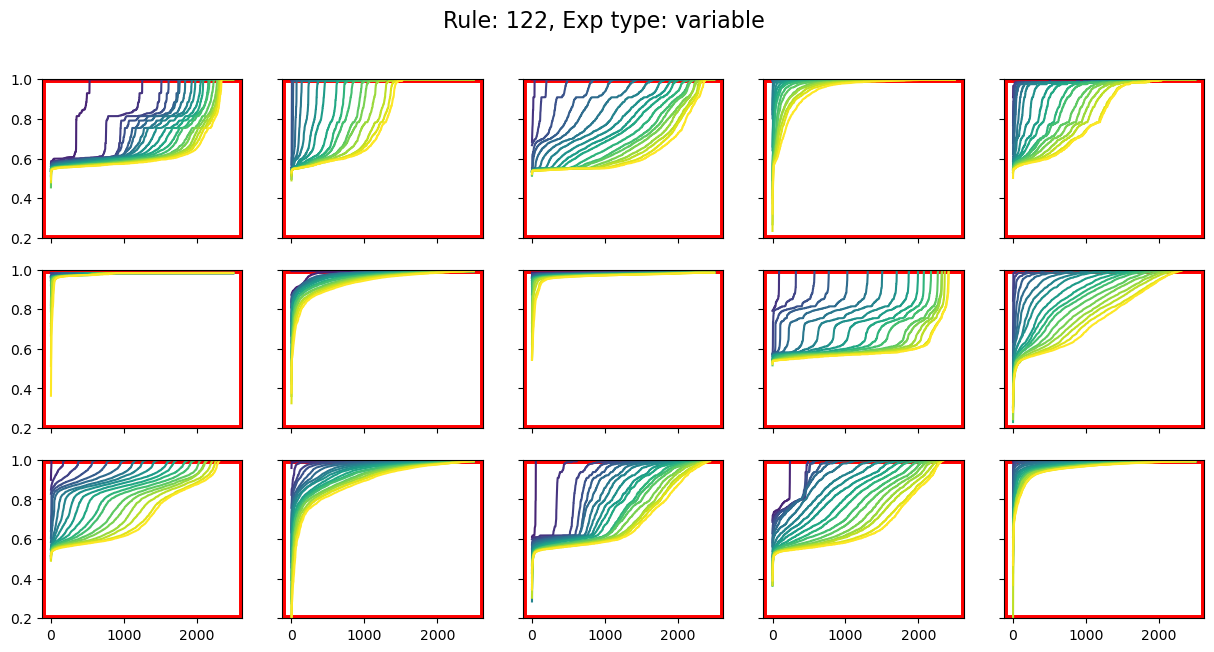

In [62]:
from matplotlib.patches import Rectangle

exp_type = "variable"

rules =[122]

mds_data = np.zeros((len(rules),2,15,10_000))
for ridx, r in enumerate(rules):
    filename = os.path.expanduser(f"{root}/noise_results/stats_{r}_{exp_type}_{candidate_idx}_env1_noise_data.jsonl")
    #filename = os.path.expanduser(f"{root}/noise_results/stats_{r}_randomGRN_noise_data.jsonl")
    log = JSONLogger(filename)

    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),sharex=True, sharey=True)
    axes = axes.flatten()

    all_data = log.read()
    c=0
    for idx, exp in enumerate(all_data):
        max_fit = 0
        if "69904" in Path(exp["file"]).name:
            data = exp["data"]
            for i, (fitnesses, noise) in enumerate(zip(data, np.linspace(0, M, N))):
                axes[c].plot(fitnesses, color=viridis((i + 1) / N), label=f"{noise:.3f}")
                #mds_data[ridx, 0, idx, ] = fitnesses
                if max(fitnesses) > max_fit:
                    max_fit = max(fitnesses)
            if max_fit > 0.9:
                rect = Rectangle((0, 0), 1, 1, transform=axes[c].transAxes,
                            color='red', linewidth=5, fill=False)
                axes[c].add_patch(rect)
            c+=1
            
    plt.ylim(0.2,1)
    fig.suptitle(f"Rule: {r}, Exp type: {exp_type}", fontsize=16)
    plt.show()

In [63]:
np.array(mds_data).shape

(1, 2, 15, 10000)

In [5]:
from scipy.ndimage import gaussian_filter1d
def make_spectrum(
    data,
    ori,
    # start value of noise sweep
    M=0.3,
    # number of values in noise sweep
    N=20,
    # number of bins in histogram
    nbins=100,
    # sigma of gaussian smoothing of histogram values
    sigma=1.0
):
    plt.style.use("seaborn-v0_8-darkgrid")
    _, ax = plt.subplots(figsize=(10, 4))
    for i, (fitnesses, noise) in enumerate(zip(data, np.linspace(0, M, N))):
        if i >3:
            counts, bins = np.histogram(fitnesses, bins=nbins, density=True)
            ax.plot(
                bins[1:],
                gaussian_filter1d(counts, sigma=sigma),
                color=viridis(i / (N - 1)),
                label=f"{noise:.3f}",
            )
    plt.axvline(ori, color="red")
    plt.xlim(0,1)
    plt.show()
    plt.style.use("default")

In [6]:
all_data = log.read()
for idx, exp in enumerate(all_data):
    data = exp["data"]
    name = Path(exp["file"]).name
    fig, ax = plt.subplots()
    rs=[]
    for i, (fitnesses, noise) in enumerate(zip(data, np.linspace(0, M, N))):
        if noise == 0:
            ori = fitnesses[0]
        ax.plot(fitnesses, color=viridis((i + 1) / N), label=f"{noise:.3f}")
        rmse = np.std(np.abs(np.array(fitnesses)[1:] - np.array(fitnesses)[:-1]))
        rs.append(rmse)

    # plt.axhline(fitnesses[0], color="red", lw=0.5)
    ax.set_ylim(0, 1.1)
    plt.grid()
    plt.ylim(0, 1.1)
    plt.ylabel("Fitness")
    plt.xlabel("Samples sorted by Fitness")
    #plt.legend()
    custom_legend(ax, title="Noise scale:", n=3)
    plt.title(name)
    plt.tight_layout()
    # plt.savefig("plots/" + name + ".fitnesses.png", dpi=300)
    # plt.close()
    plt.show()

    fig, ax = plt.subplots()
    for i, fitnesses in enumerate(data):
        # label=f"{np.linspace(0,M,N)[i]:.3f}"
        ax.plot(np.array(fitnesses) - i / 80, color=viridis((i + 1) / N))
    # ax.annotate(
    #     "different levels of noise\n(displaced for visibility)",
    #     xy=(2300, 0.75),
    #     xytext=(1500, 0.3),
    #     arrowprops=dict(fc="gray", ec="None", shrink=0.01),
    # )
    plt.grid()
    plt.yticks([])
    plt.xticks([])
    plt.ylabel("Fitness")
    plt.xlabel("Samples sorted by Fitness")
    # plt.legend()
    plt.title(name)
    plt.tight_layout()
    # plt.savefig("plots/" + name + ".stagger.png", dpi=300)
    # plt.close()
    plt.show()

    make_spectrum(data, ori)

    #plt.plot(rs)
    #plt.show()

NameError: name 'log' is not defined

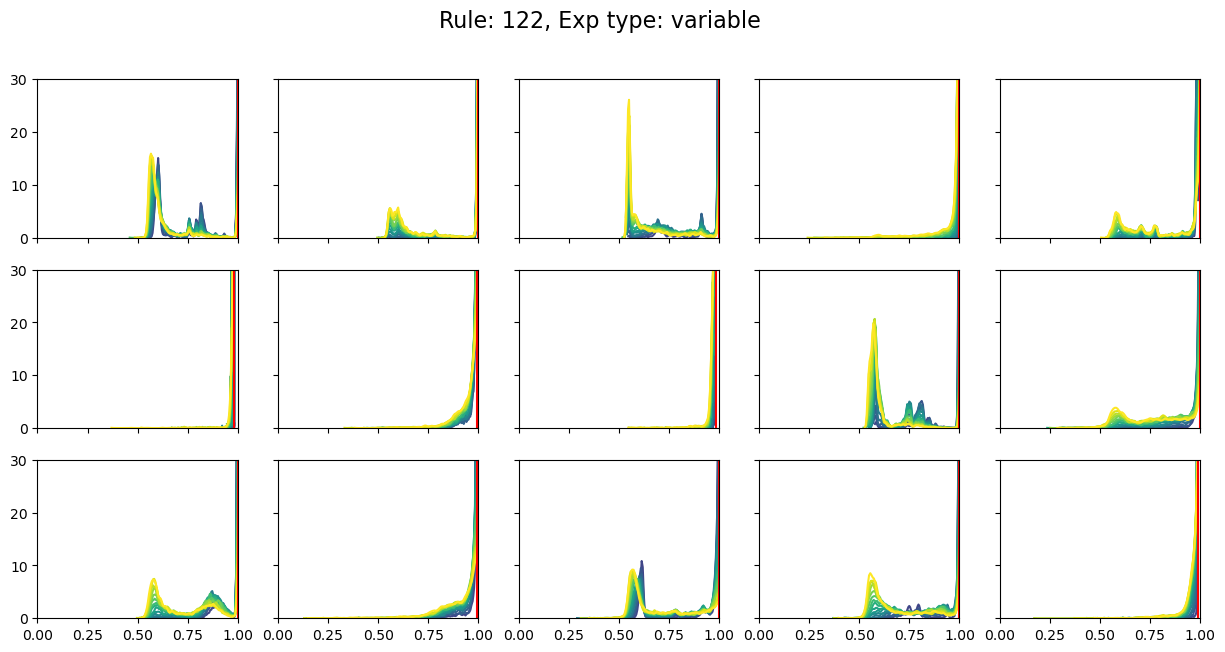

In [65]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),sharex=True, sharey=True)
axes = axes.flatten()

all_data = log.read()
c=0
for idx, exp in enumerate(all_data):
    max_fit = 0
    if "69904" in Path(exp["file"]).name:
        data = exp["data"]

        for i, (fitnesses, noise) in enumerate(zip(data, np.linspace(0, M, N))):
                if noise == 0:
                    ori = fitnesses[0]
                if i >3:
                    counts, bins = np.histogram(fitnesses, bins=100, density=True)
                    axes[c].plot(
                        bins[1:],
                        gaussian_filter1d(counts, sigma=1.0),
                        color=viridis(i / (N - 1)),
                        label=f"{noise:.3f}",
                    )
        axes[c].axvline(ori, color="red")
        c+=1
        

plt.xlim(0,1)
plt.ylim(0,30)
fig.suptitle(f"Rule: {r}, Exp type: {exp_type}", fontsize=16)
plt.show()

In [67]:
r, exp_type, candidate_idx

(122, 'variable', 299)

In [74]:
rules = [22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102]

0.6393511082086729
1.7102710087828935e-53


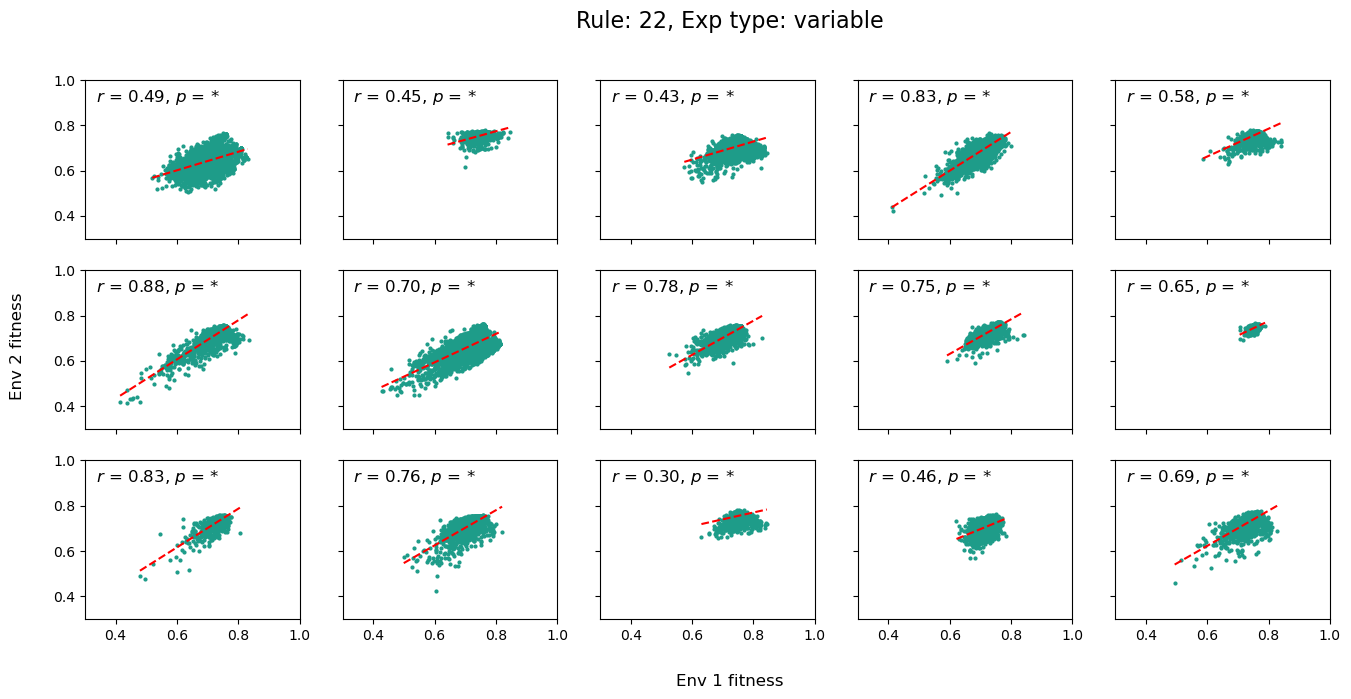

0.0028279708263429276
0.07509969370410298


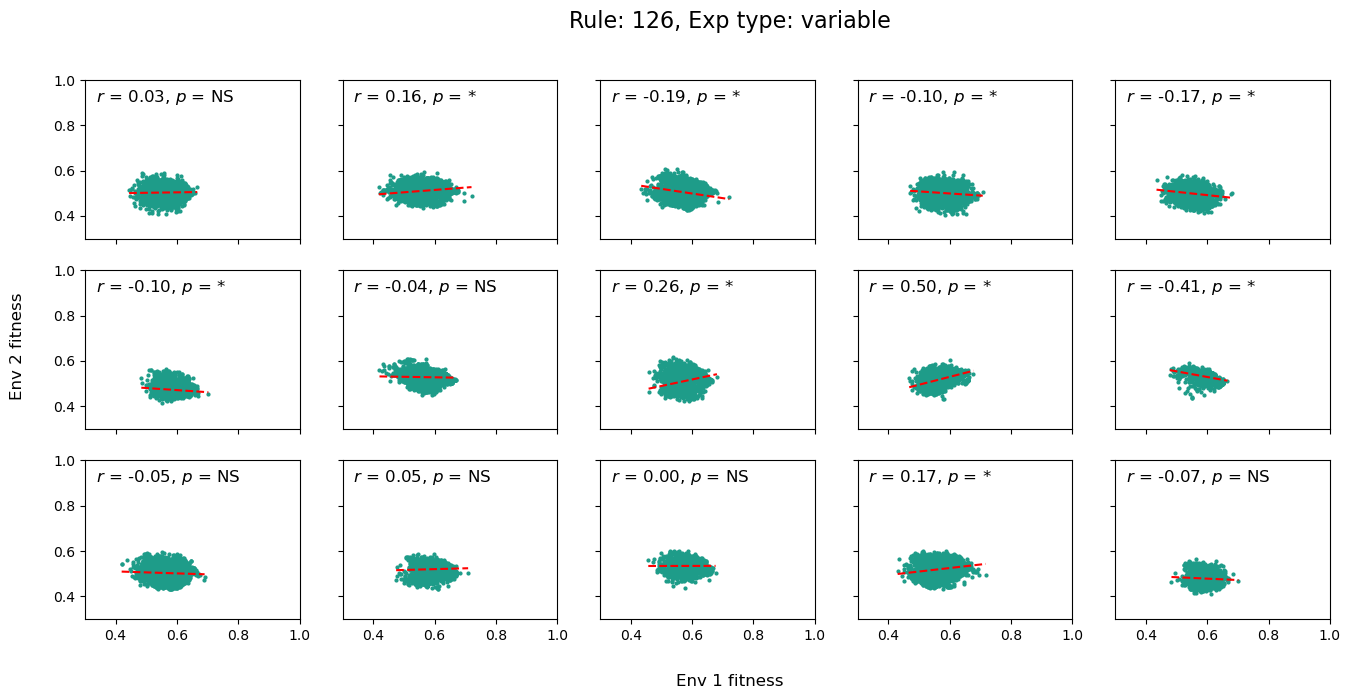

0.10299741995397017
0.02795608577503962


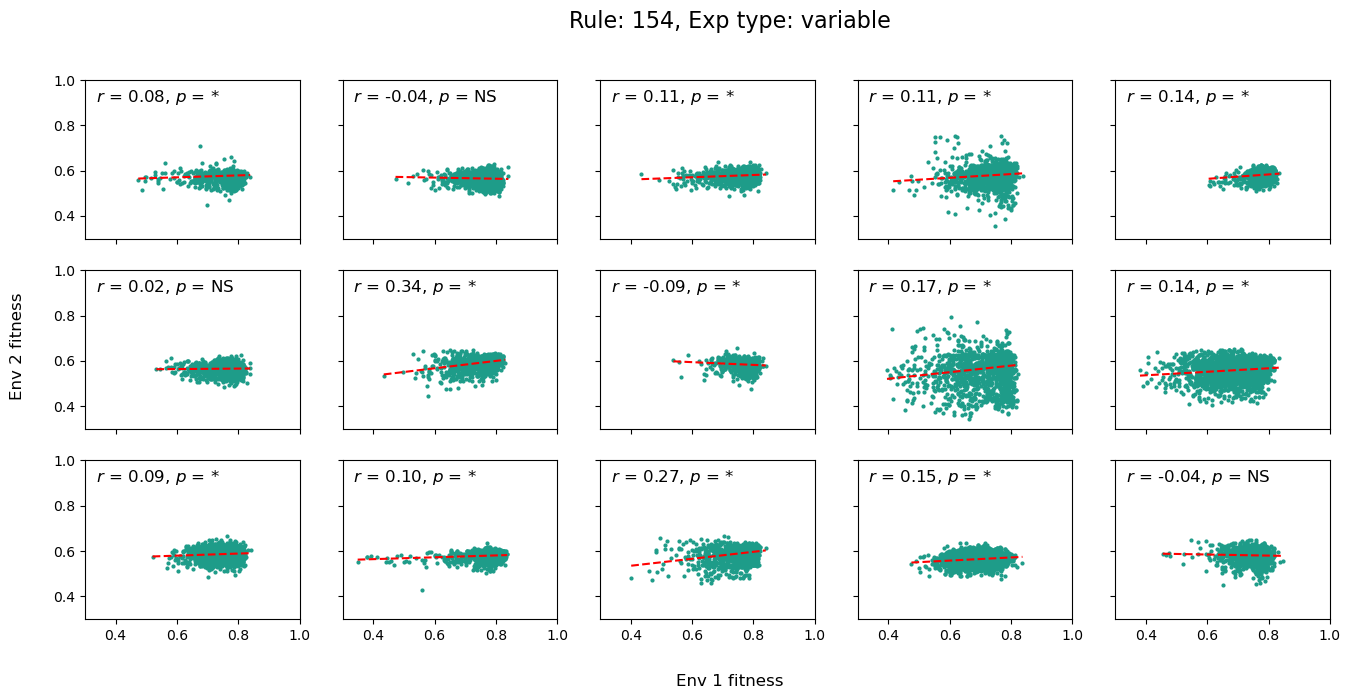

0.43252189738080216
0.008575759866960882


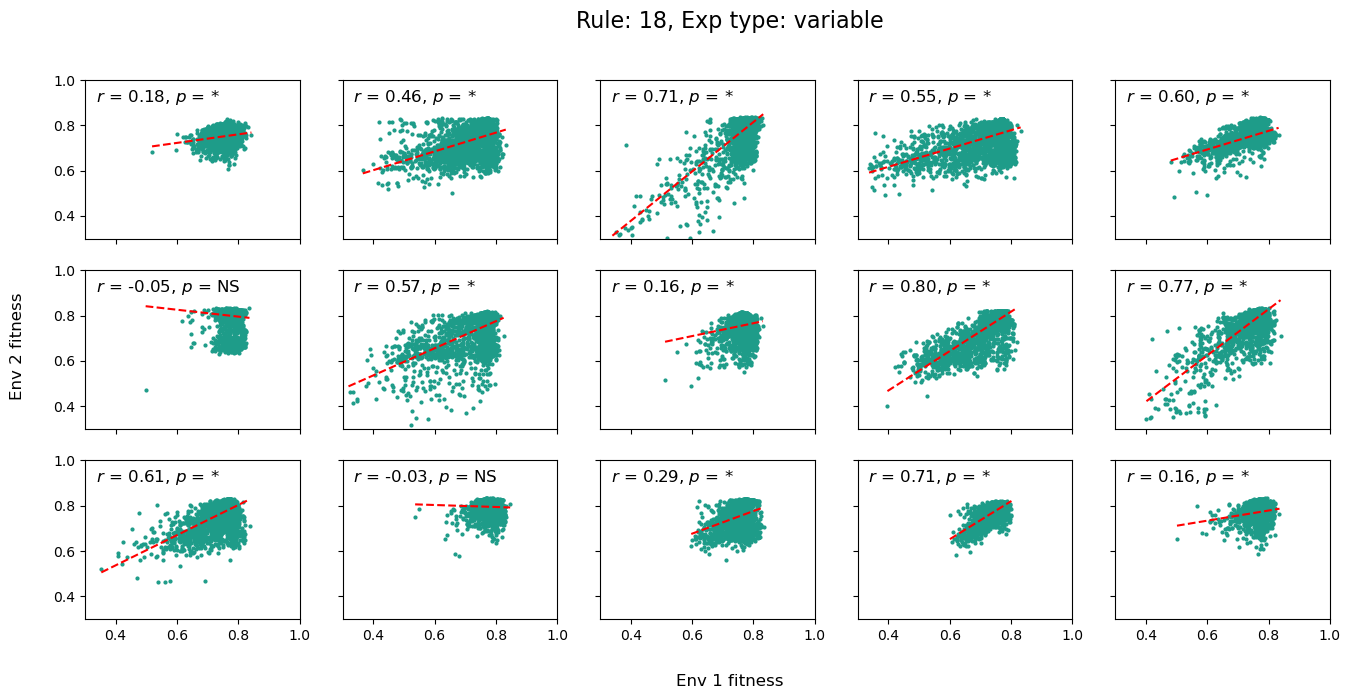

0.17904207315466134
0.06729235464674307


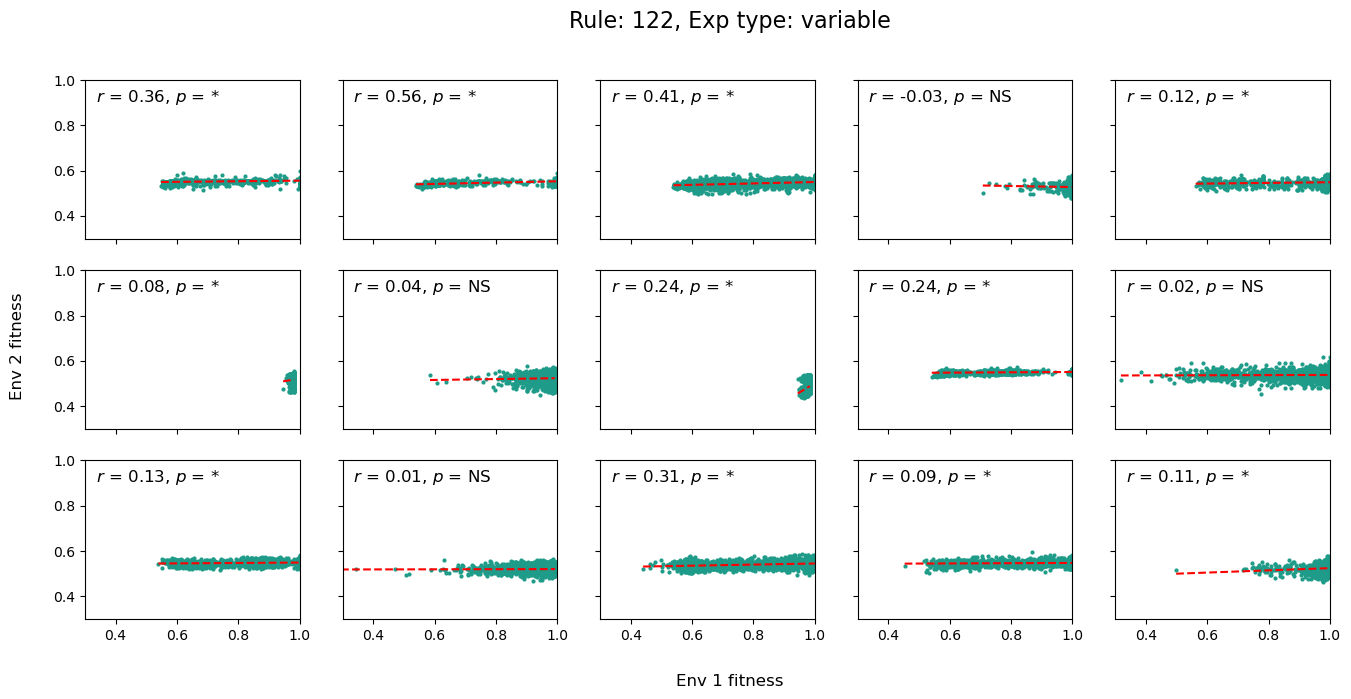

0.32332230515241406
0.035470951107162696


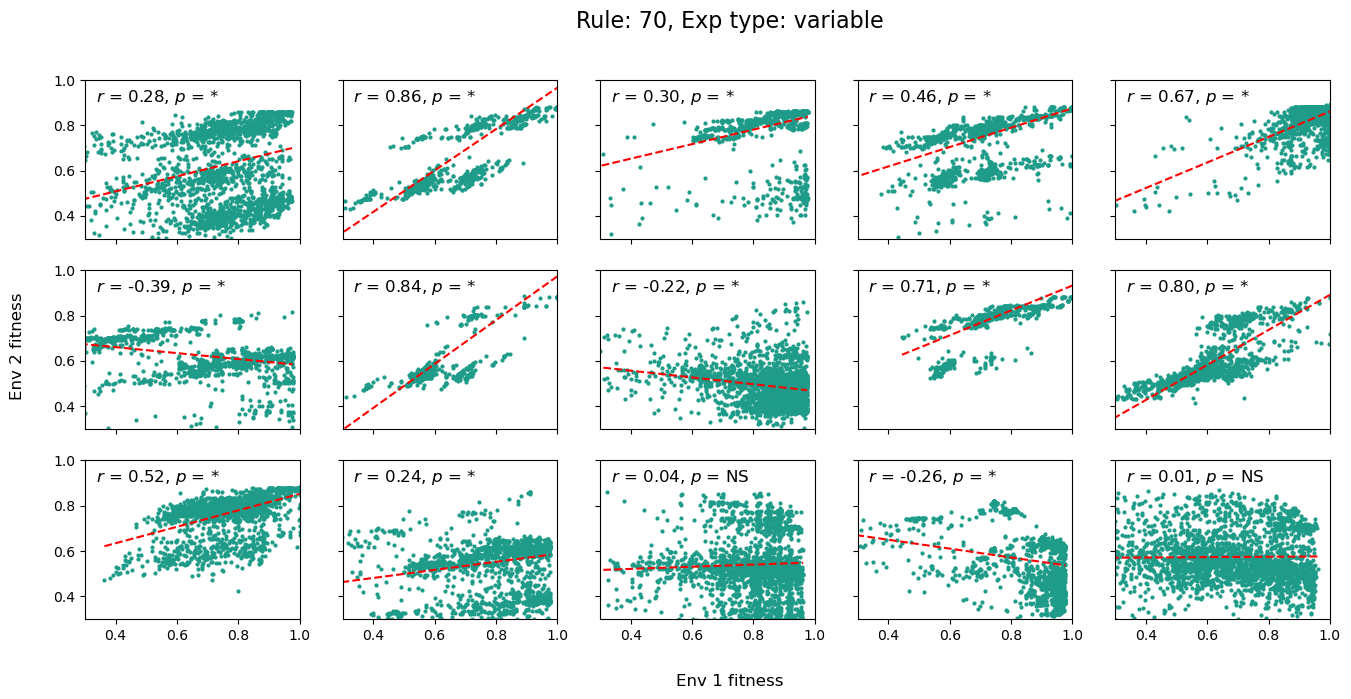

0.4136238602881638
1.4849100336895427e-08


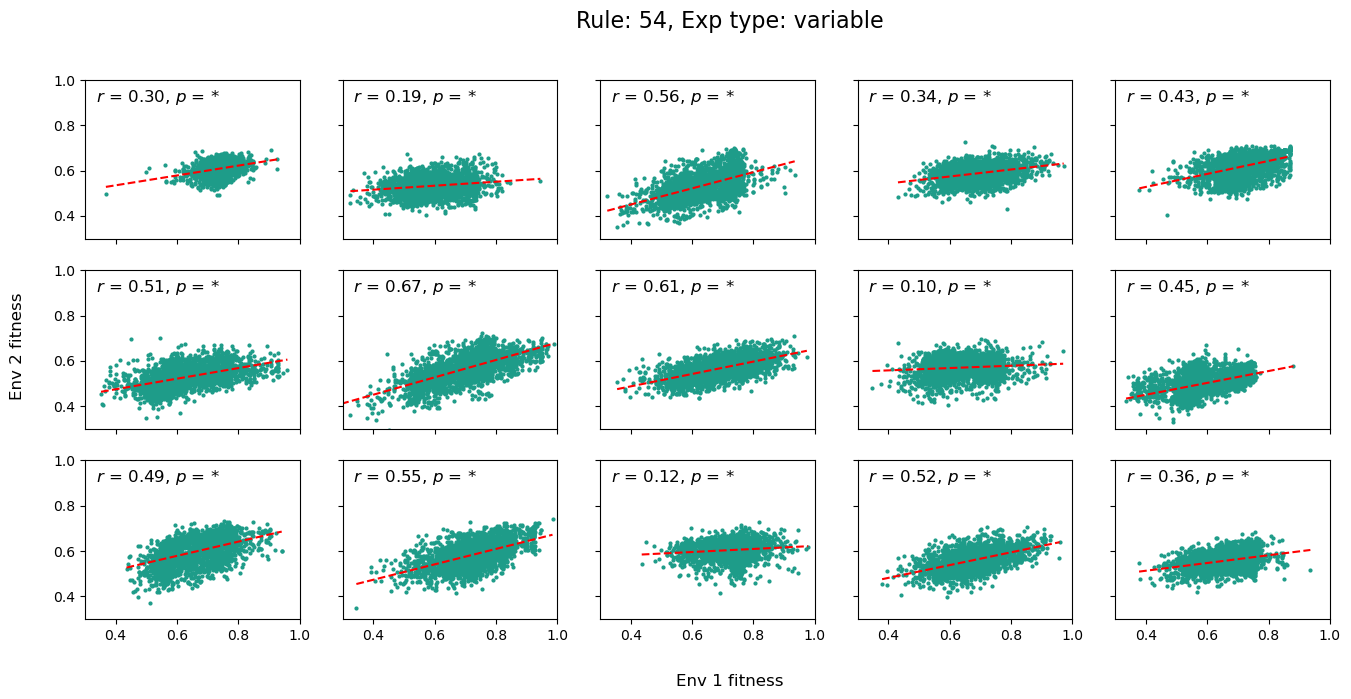

-0.11139895543901522
0.007298562725697098


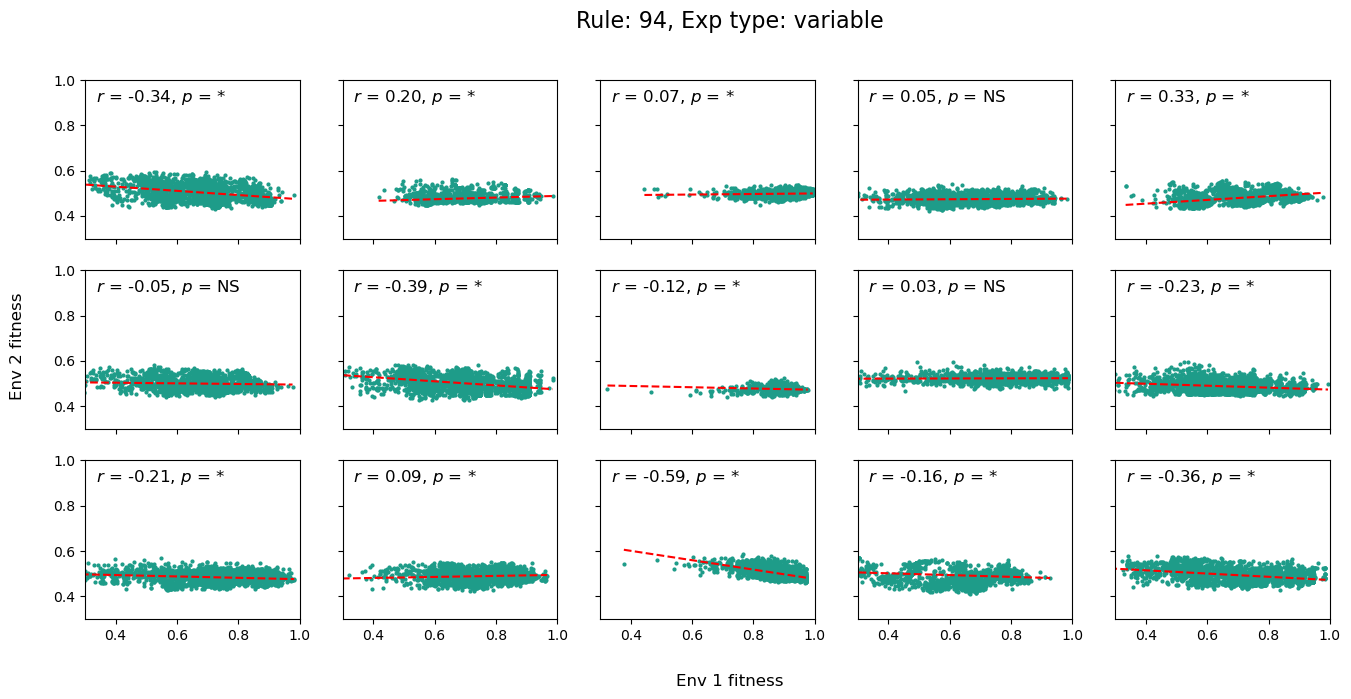

0.32521312791143714
0.0016009434197581274


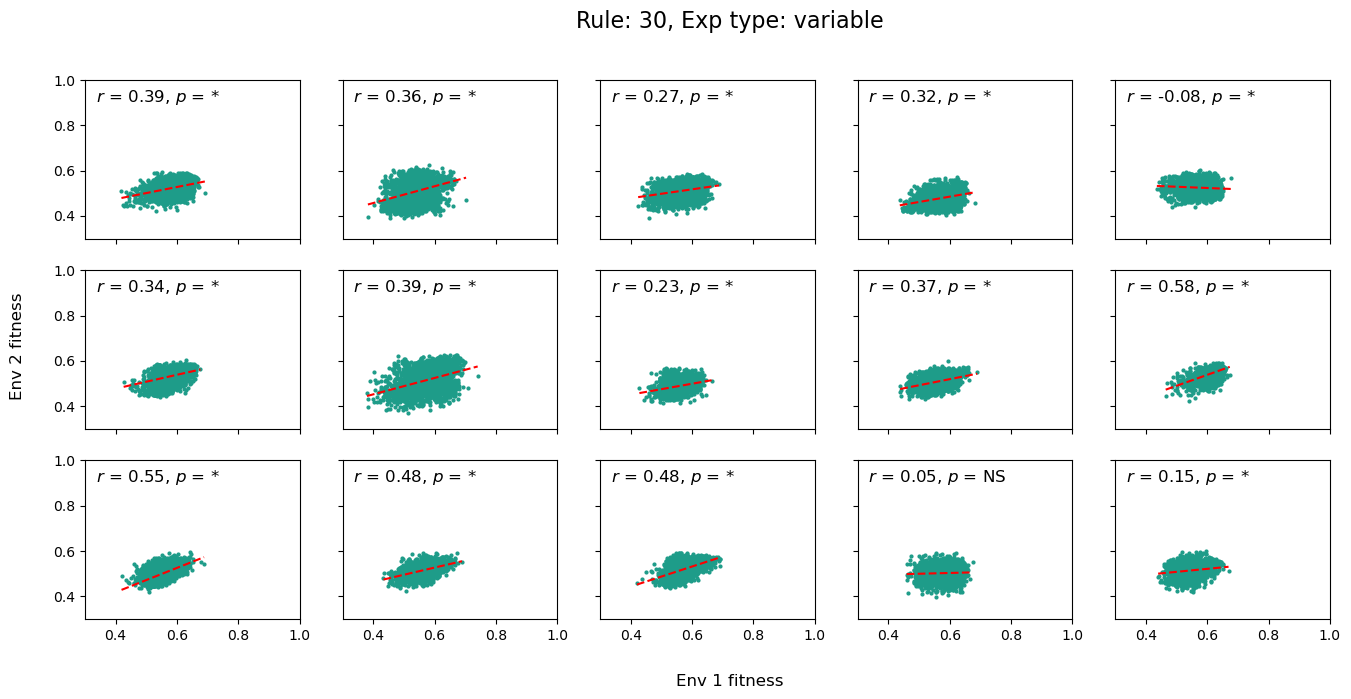

0.3013602154530283
0.021180857947985014


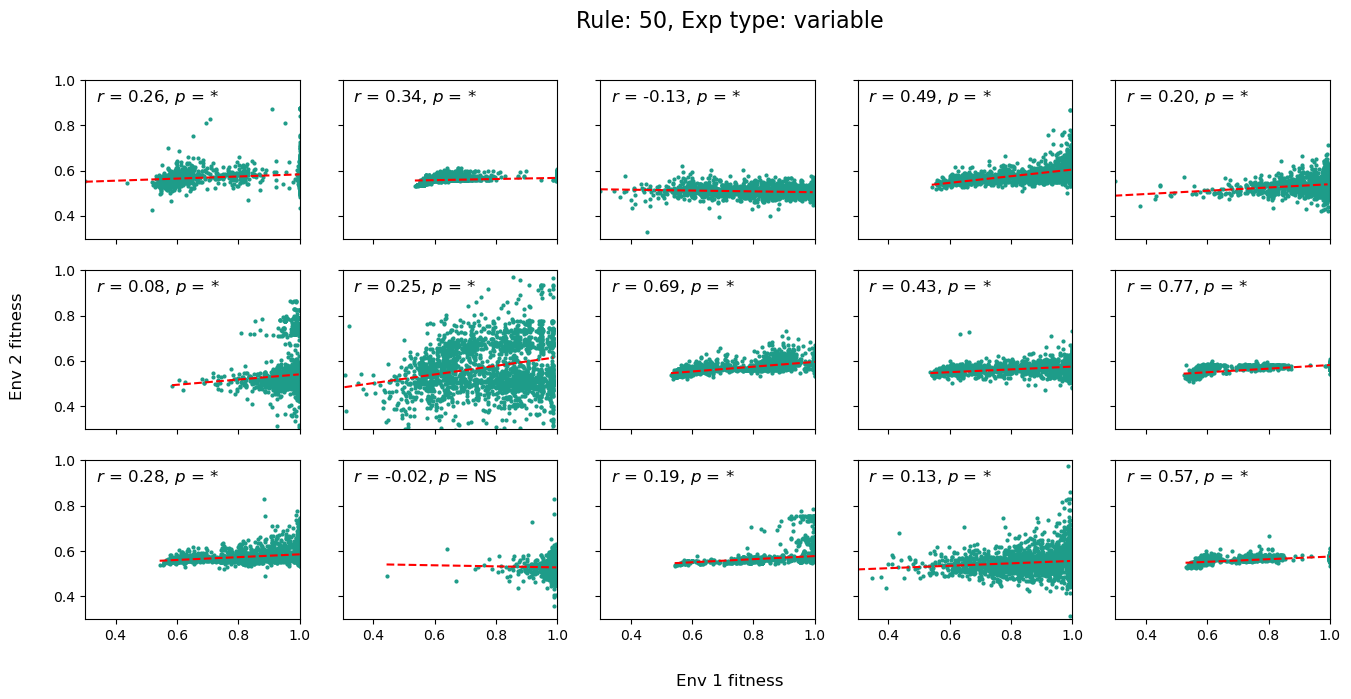

-0.10653699738545504
0.10081620093212436


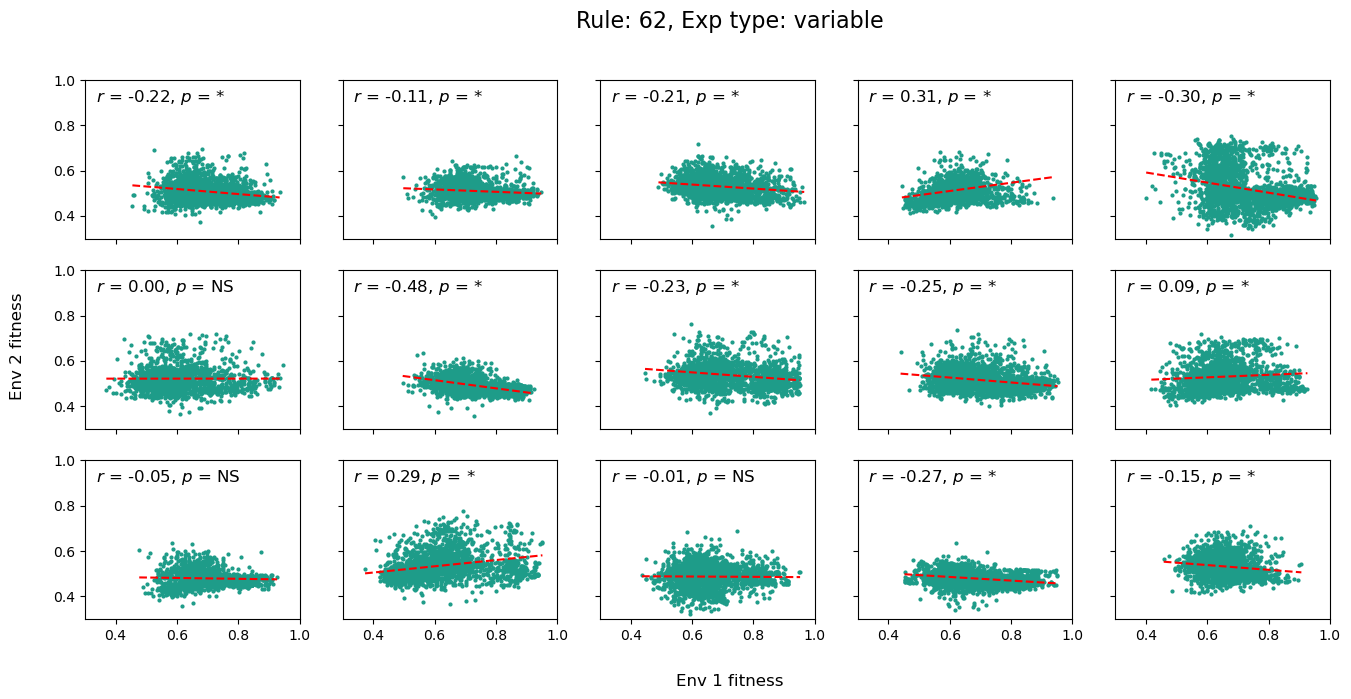

-0.09720988583751465
0.027950474598180126


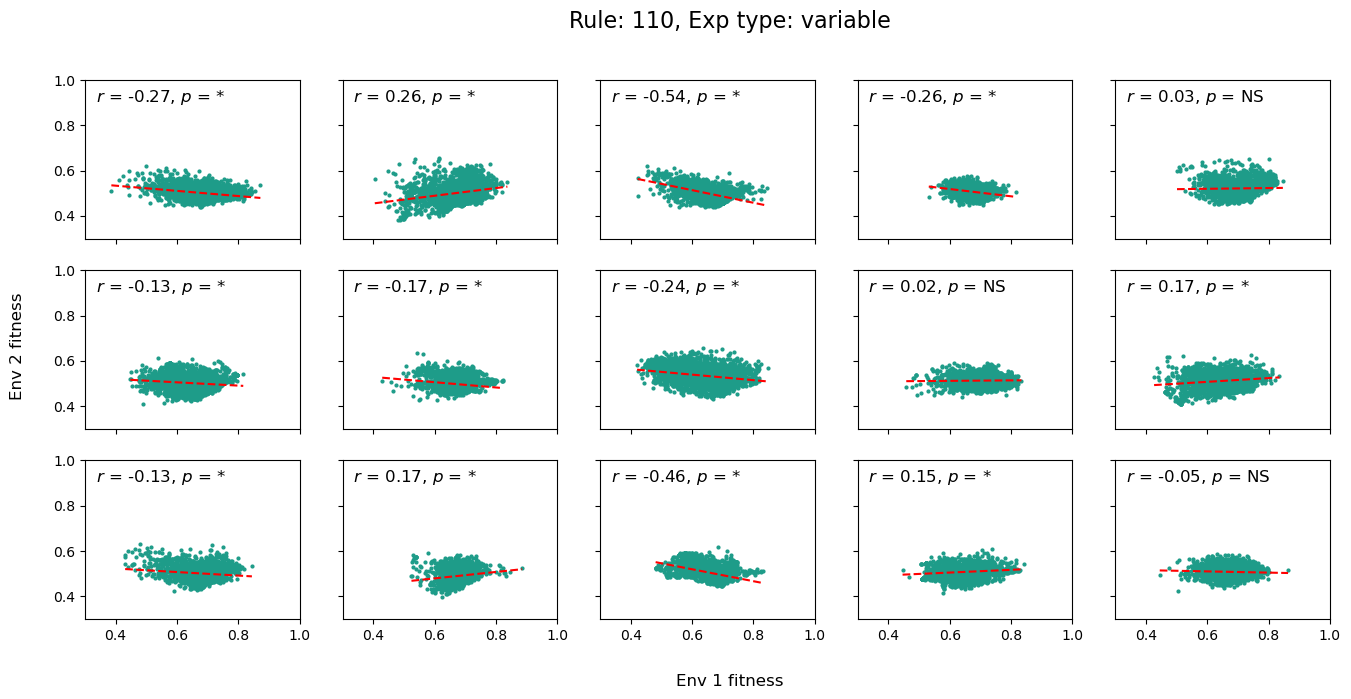

0.25330734443257524
3.8285954223853535e-05


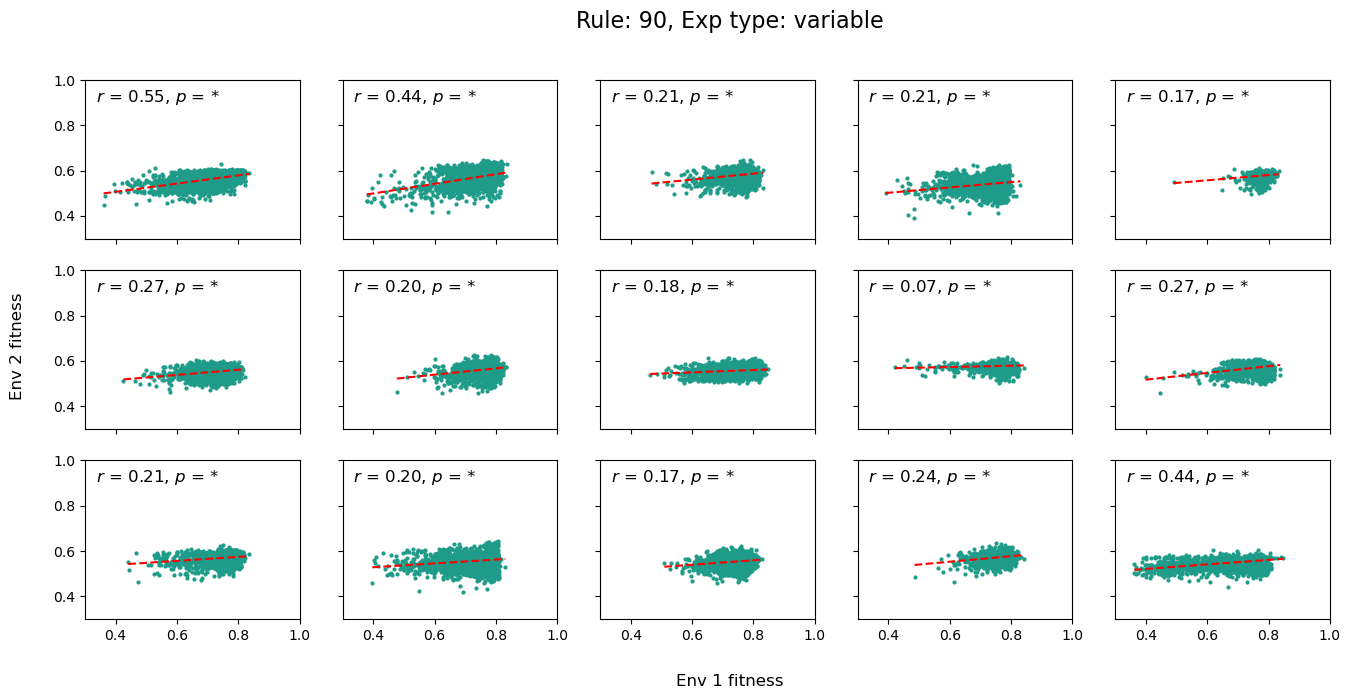

-0.17050570674378543
7.964249612044936e-07


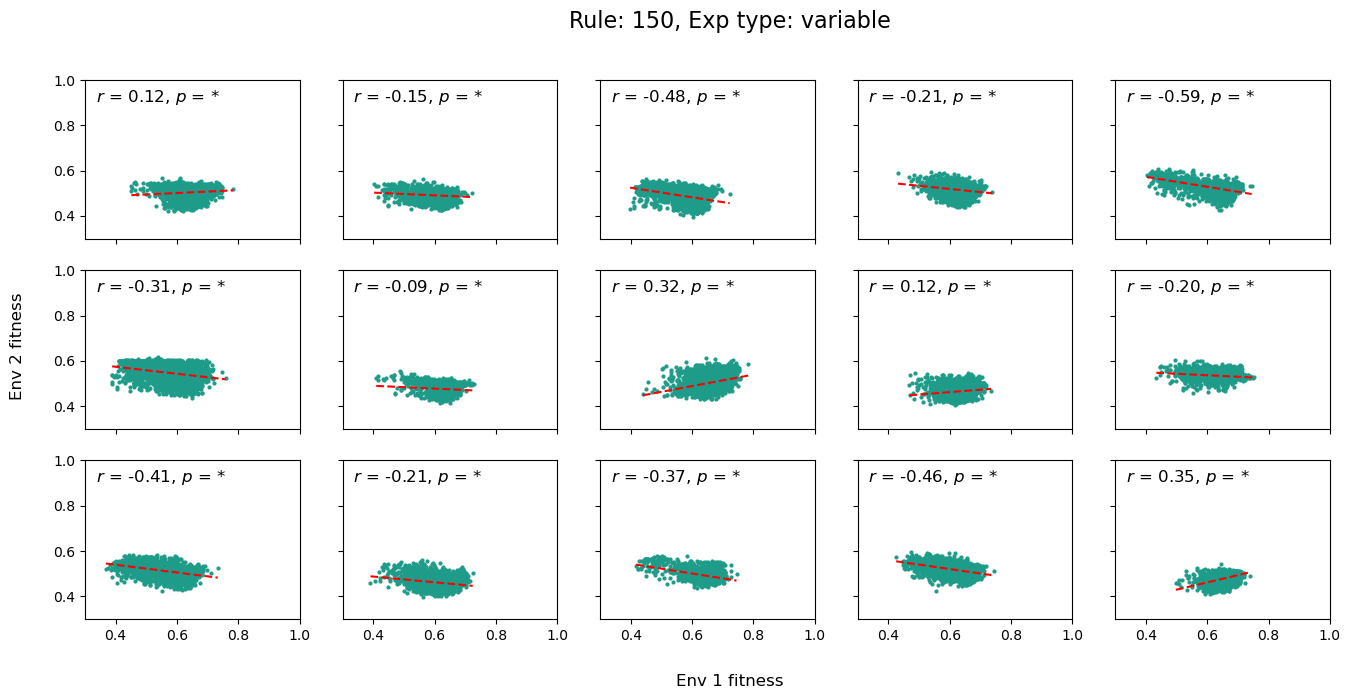

0.6813154953380863
3.70033555844784e-20


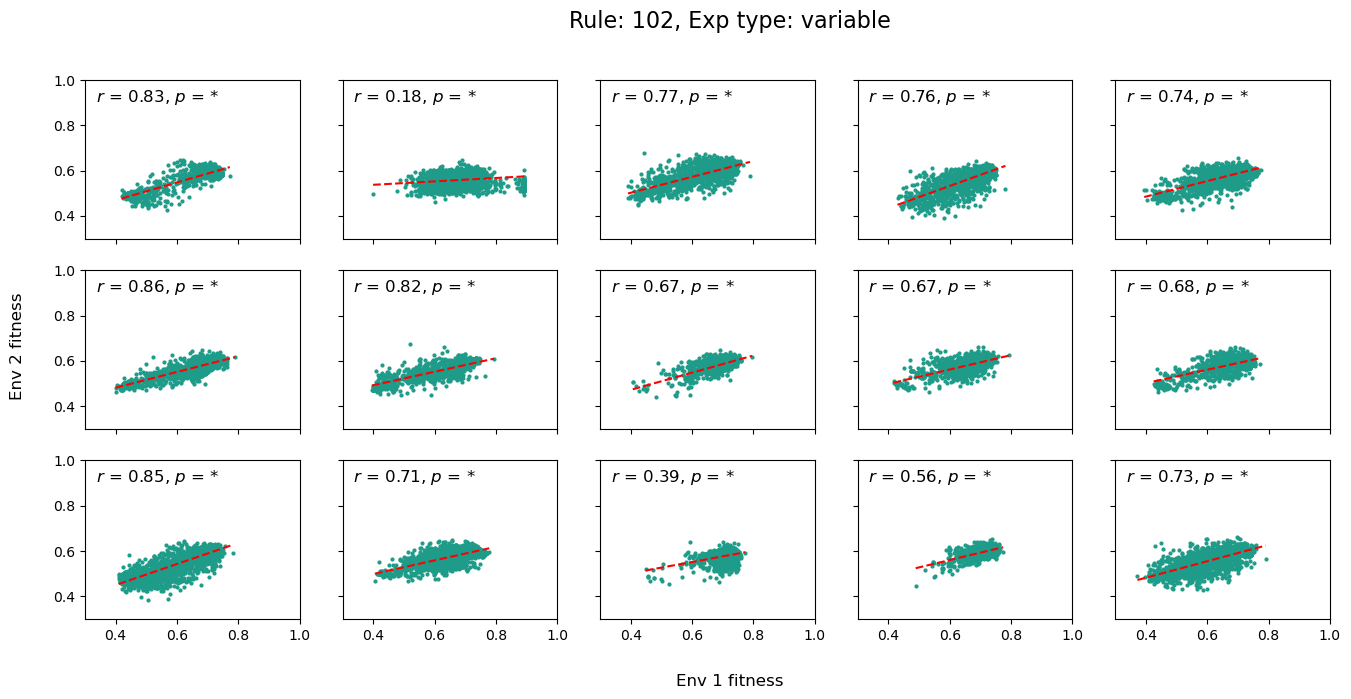

In [43]:
root="~/scratch/detailed_save/"
exp_type = 'variable'
candidate_idx = 299
M=0.3
N=20
rss=[]
for r in rules:
    filename = os.path.expanduser(f"{root}/noise_results/stats_{r}_{exp_type}_{candidate_idx}_env1_unsorted_noise_data.jsonl")
    #filename = os.path.expanduser(f"{root}/noise_results/stats_{r}_randomGRN_noise_data.jsonl")
    log = JSONLogger(filename)
    all_data1 = log.read()

    filename = os.path.expanduser(f"{root}/noise_results/stats_{r}_{exp_type}_{candidate_idx}_env2_unsorted_noise_data.jsonl")
    #filename = os.path.expanduser(f"{root}/noise_results/stats_{r}_randomGRN_noise_data.jsonl")
    log = JSONLogger(filename)
    all_data2 = log.read()

    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),sharex=True, sharey=True)
    axes = axes.flatten()

    rs=[]
    ps=[]
    for i in range(15):
        data1 = all_data1[i]["data"]
        data2 = all_data2[i]["data"]
        for idx, noise in enumerate(np.linspace(0, M, N)):
            if idx == 10:
                axes[i].scatter(data1[idx], data2[idx], color=viridis((idx + 1) / N), label=f"{noise:.3f}",s=4)
                x = data1[idx]
                y = data2[idx]
                slope, intercept, r_value, p_value, std_err = linregress(x, y)
                x_fit = np.linspace(min(x), max(x), 100)
                y_fit = slope * x_fit + intercept
                axes[i].plot(x_fit, y_fit, color='red', linestyle='--', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')
                sig = "NS"
                if p_value <= 0.001:
                    sig="*"
                axes[i].text(0.05, 0.95, f'$r$ = {r_value:.2f}, $p$ = {sig}',transform=axes[i].transAxes, verticalalignment='top', fontsize=12)
                ps.append(p_value)
                rs.append(r_value)
                #axes[i].plot([0.3, 1], [0.3, 1], color='black', linestyle='--', linewidth=2, label='Diagonal Line', alpha=0.5)
    print(sum(rs)/len(rs))
    rss.append(sum(rs)/len(rs))
    print(sum(ps)/len(ps))
    plt.xlim(0.3,1)
    plt.ylim(0.3,1)
    fig.supxlabel("Env 1 fitness", fontsize=12)
    fig.supylabel("Env 2 fitness", fontsize=12)
    fig.subplots_adjust(left=0.07)
    fig.suptitle(f"Rule: {r}, Exp type: {exp_type}", fontsize=16)
    plt.show()

In [81]:
ave_gen = [0.8442785102268743, 0.6627563973186956, 0.6149340145957056, 0.8101618739290598, 0.4837287169030042, 0.1800027498423489, 0.5917060643820021, 0.5289486156552087, 0.6997468267363909, 0.31250091865937496, 0.5176185214405673, 0.5615396521138244, 0.6782059161424832, 0.6087023255979291, 0.6162314537716285]
ave_div = [0.38063234677599855, 0.247048024685225, 0.43127418549499585, 0.4460694105081499, 0.3828395202156512, 0.5058663992850627, 0.43081092914320307, 0.3632841704008617, 0.2703650944055716, 0.5069311842532878, 0.4039776416603812, 0.3529240336480045, 0.34242421751677427, 0.2762463295208969, 0.3741760726583794]

In [82]:
rules

[22, 126, 154, 18, 122, 70, 54, 94, 30, 50, 62, 110, 90, 150, 102]

In [91]:
reach_max = []#[50,70] #54,102]
rules_mask = []
for i, r in enumerate(rules):
    if r not in reach_max:
        rules_mask.append(i)
rules_mask

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

Text(0, 0.5, 'inter-landscape r correlation')

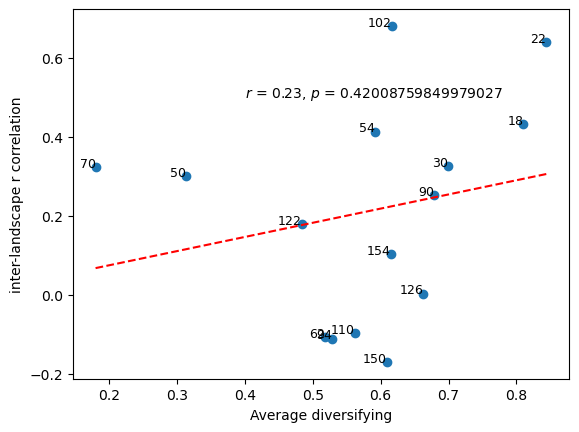

In [94]:
x=list(np.array(ave_gen)[rules_mask])
y=list(np.array(rss)[rules_mask])

plt.scatter(x,y)

slope, intercept, r_value, p_value, std_err = linregress(x, y)
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, color='red', linestyle='--', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')
plt.text(0.4, 0.5, f'$r$ = {r_value:.2f}, $p$ = {p_value}')

for i, label in enumerate(np.array(rules)[rules_mask]):
    plt.text(x[i], y[i], label, fontsize=9, ha='right')

plt.xlabel("Average diversifying")
#plt.ylabel("Average diversifying")
plt.ylabel("inter-landscape r correlation")
